# Merge exps_performance accuracy into exps_logistic results

This notebook parses logistic result filenames to extract `(model, seed, rep)`, loads corresponding performance `res.jsonl` files, computes task-averaged accuracy (excluding `gsm8k`), and merges the accuracy into the logistic dataframes.

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import Dict, Tuple

import pandas as pd

# Base paths
LOGISTIC_RESULTS_DIR = Path("/nlpgpu/data/terry/ToolProj/src/exps_logistic/results")
PERF_RESULTS_DIR = Path("/nlpgpu/data/terry/ToolProj/src/exps_performance/results")

pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)

In [2]:
import re

FILENAME_RE = re.compile(r"^(?P<model>.+)_seed(?P<seed>\d+)_(?P<rep>nl|code)_(?P<feats>[^_]+)-(?P<embed>[^_]+)_(?P<ts>\d{8}_\d{6})\.json$")


def parse_logistic_filename(path: Path) -> Tuple[str, int, str]:
    """Parse logistic result filename into (model, seed, rep).

    Expected pattern: {model}_seed{seed}_{rep}_{feats}-{embed}_{timestamp}.json
    """
    m = FILENAME_RE.match(path.name)
    if not m:
        raise ValueError(f"Unexpected filename format: {path.name}")
    model = m.group("model")
    seed = int(m.group("seed"))
    rep = m.group("rep")
    return model, seed, rep


# Quick sanity check on existing files
sample_files = sorted(LOGISTIC_RESULTS_DIR.glob("*.json"))[:3]
[(p.name, parse_logistic_filename(p)) for p in sample_files]

[('claude-haiku-4.5_seed0_code_hf-cls-google-bert-bert-base-uncased_20260109_120107.json',
  ('claude-haiku-4.5', 0, 'code')),
 ('claude-haiku-4.5_seed0_code_hf-cls-google-bert-bert-base-uncased_20260109_161842.json',
  ('claude-haiku-4.5', 0, 'code')),
 ('claude-haiku-4.5_seed0_nl_hf-cls-google-bert-bert-base-uncased_20260109_120133.json',
  ('claude-haiku-4.5', 0, 'nl'))]

In [3]:
# Load logistic results into dataframes keyed by (model, seed, rep)
logistic_dfs: Dict[Tuple[str, int, str], pd.DataFrame] = {}

for path in sorted(LOGISTIC_RESULTS_DIR.glob("*.json")):
    model, seed, rep = parse_logistic_filename(path)
    with path.open("r") as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    df["model"] = model
    df["seed"] = seed
    df["rep"] = rep
    logistic_dfs[(model, seed, rep)] = df

logistic_keys = sorted(logistic_dfs.keys())
logistic_keys[:5], len(logistic_keys)

([('claude-haiku-4.5', 0, 'code'),
  ('claude-haiku-4.5', 0, 'nl'),
  ('claude-haiku-4.5', 1, 'code'),
  ('claude-haiku-4.5', 1, 'nl'),
  ('claude-haiku-4.5', 2, 'code')],
 32)

In [4]:
REP_TO_COL = {
    "nl": "nl_correct",
    "code": "code_correct",
}

perf_accuracy: Dict[Tuple[str, int, str], float] = {}
missing_perf = []

for model, seed, _ in sorted({(m, s, r)[:2] + ("",) for m, s, r in logistic_keys}):
    perf_dir = PERF_RESULTS_DIR / f"{model}_seed{seed}"
    res_files = sorted(perf_dir.glob("tb/run_*/res.jsonl"))
    if not res_files:
        missing_perf.append((model, seed))
        continue
    perf_df_list = []
    for rf in res_files:
        try:
            perf_df_list.append(pd.read_json(rf, lines=True))
        except ValueError as exc:
            print(f"Skipping {rf}: {exc}")
    if not perf_df_list:
        missing_perf.append((model, seed))
        continue
    perf_df = pd.concat(perf_df_list, ignore_index=True)
    perf_df = perf_df[perf_df["kind"] != "gsm8k"]

    for rep, col in REP_TO_COL.items():
        if col not in perf_df.columns:
            continue
        # Macro-average: mean per kind, then mean across kinds
        by_kind = perf_df.groupby("kind")[col].mean()
        acc = by_kind.mean() if len(by_kind) else float("nan")
        perf_accuracy[(model, seed, rep)] = acc

perf_accuracy_sample = list(perf_accuracy.items())[:5]
perf_accuracy_sample, len(perf_accuracy), missing_perf[:5]

([(('claude-haiku-4.5', 0, 'nl'), 0.18485163277481798),
  (('claude-haiku-4.5', 0, 'code'), 0.28479470680268554),
  (('claude-haiku-4.5', 1, 'nl'), 0.17443435361608015),
  (('claude-haiku-4.5', 1, 'code'), 0.27380863134913097),
  (('claude-haiku-4.5', 2, 'nl'), 0.1857535813242165)],
 32,
 [])

In [5]:
merged_dfs: Dict[Tuple[str, int, str], pd.DataFrame] = {}

for key, df in logistic_dfs.items():
    acc = perf_accuracy.get(key, float("nan"))
    df = df.copy()
    df["accuracy_performance"] = acc
    merged_dfs[key] = df

summary_rows = []
for (model, seed, rep), acc in sorted(perf_accuracy.items()):
    summary_rows.append({"model": model, "seed": seed, "rep": rep, "accuracy_performance": acc})
summary_df = pd.DataFrame(summary_rows)
summary_df.head(), len(summary_df)

(              model  seed   rep  accuracy_performance
 0  claude-haiku-4.5     0  code              0.284795
 1  claude-haiku-4.5     0    nl              0.184852
 2  claude-haiku-4.5     1  code              0.273809
 3  claude-haiku-4.5     1    nl              0.174434
 4  claude-haiku-4.5     2  code              0.277499,
 32)

In [6]:
# Inspect one merged dataframe
first_key = next(iter(merged_dfs))
first_key, merged_dfs[first_key].head()

(('claude-haiku-4.5', 0, 'code'),
                                            rationale           kind  digits  \
 0  ```python\ndef solution() -> int:\n    W = [27...           knap    18.0   
 1  ```python\ndef solution() -> int:\n    result ...            sub     4.0   
 2  python\ndef solution() -> int:\n    from pulp ...       ilp_prod    12.0   
 3  ```python\ndef solution() -> int:\n    W = [2,...           knap     4.0   
 4  ```python\ndef solution() -> int:\n    weights...  ilp_partition     2.0   
 
                                               prompt           true_label  \
 0  0/1 Knapsack: Given item weights W and values ...         knap|d18|b24   
 1                               Compute: 2931 - 1926            sub|d4|b8   
 2  Production planning: Choose integer quantities...     ilp_prod|d12|b53   
 3  0/1 Knapsack: Given item weights W and values ...          knap|d4|b28   
 4  Partition: Split the items into two groups to ...  ilp_partition|d2|b0   
 
             p

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr, wilcoxon

# Set seaborn style for better aesthetics
sns.set_style("whitegrid")
sns.set_palette("husl")


# Build one-row-per-(model, seed, rep) summary
def build_summary_df(merged: Dict[Tuple[str, int, str], pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for (model, seed, rep), df in merged.items():
        # metrics row is the one with mutual_info_lower_bound_bits present
        metrics_row = df[df["mutual_info_lower_bound_bits"].notna()].tail(1)
        if metrics_row.empty:
            continue
        mi_bits = float(metrics_row["mutual_info_lower_bound_bits"].iloc[0])
        acc_perf = float(df["accuracy_performance"].iloc[0])
        rows.append(
            {
                "model": model,
                "seed": seed,
                "rep": rep,
                "mutual_info_lower_bound_bits": mi_bits,
                "accuracy_performance": acc_perf,
            }
        )
    return pd.DataFrame(rows)


summary_corr_df = build_summary_df(merged_dfs)
summary_corr_df.head(), len(summary_corr_df)

(              model  seed   rep  mutual_info_lower_bound_bits  \
 0  claude-haiku-4.5     0  code                      3.569967   
 1  claude-haiku-4.5     0    nl                      3.897805   
 2  claude-haiku-4.5     1  code                      3.593977   
 3  claude-haiku-4.5     1    nl                      3.830682   
 4  claude-haiku-4.5     2  code                      3.557598   
 
    accuracy_performance  
 0              0.284795  
 1              0.184852  
 2              0.273809  
 3              0.174434  
 4              0.277499  ,
 32)

Contrast rows:
                           model seed delta_mi_bits delta_acc
rep                                                          
0               claude-haiku-4.5    0     -0.327838  0.099943
1               claude-haiku-4.5    1     -0.236704  0.099374
2               claude-haiku-4.5    2     -0.243642  0.091745
3               gemini-2.5-flash    0      0.390335  0.000000
4               gemini-2.5-flash    1      0.021739  0.101735
5               gemini-2.5-flash    2     -0.252629  0.000000
6                    gpt-4o-mini    0      0.258520  0.117784
7                    gpt-4o-mini    1      0.298036  0.118307
8                    gpt-4o-mini    2      0.227133 -0.032962
9        llama-3.1-405b-instruct    0      0.511261  0.001746
10       llama-3.1-405b-instruct    1      0.550334 -0.003784
11       llama-3.1-405b-instruct    2      0.304830  0.000000
12            ministral-14b-2512    1      0.122617  0.132832
13   qwen-2.5-coder-32b-instruct    0      0.499934  0.

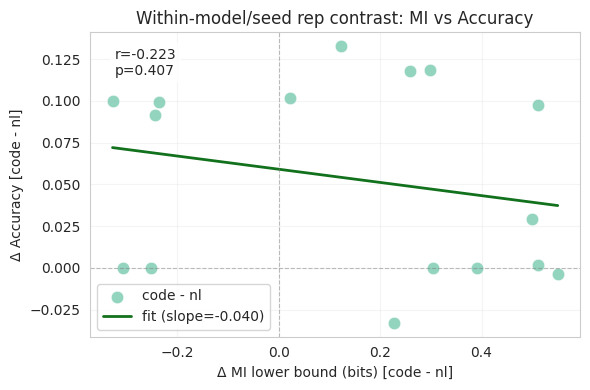

In [8]:
# Within-rep contrasts: code vs nl deltas per (model, seed)
wide = summary_corr_df.pivot_table(
    index=["model", "seed"],
    columns="rep",
    values=["mutual_info_lower_bound_bits", "accuracy_performance"],
)
# keep only rows with both reps present and no NaNs
wide = wide.dropna()

contrast_df = wide.copy()
contrast_df["delta_mi_bits"] = contrast_df["mutual_info_lower_bound_bits"]["code"] - contrast_df["mutual_info_lower_bound_bits"]["nl"]
contrast_df["delta_acc"] = contrast_df["accuracy_performance"]["code"] - contrast_df["accuracy_performance"]["nl"]
contrast_flat = contrast_df.reset_index()[["model", "seed", "delta_mi_bits", "delta_acc"]]

print("Contrast rows:")
print(contrast_flat)

if len(contrast_flat) < 2 or contrast_flat["delta_mi_bits"].nunique() < 2:
    print("Not enough distinct points for correlation/regression.")
else:
    r_d, p_d = pearsonr(contrast_flat["delta_mi_bits"], contrast_flat["delta_acc"])
    print(f"Delta Pearson r = {r_d:.3f}, p = {p_d:.3g}, N = {len(contrast_flat)}")

    x_d = contrast_flat["delta_mi_bits"].to_numpy()
    y_d = contrast_flat["delta_acc"].to_numpy()

    slope_d, intercept_d = np.polyfit(x_d, y_d, 1)
    x_line_d = np.linspace(x_d.min(), x_d.max(), 100)
    y_line_d = slope_d * x_line_d + intercept_d

    # Use seaborn qualitative palette for scatter points
    palette = sns.color_palette("Set2", n_colors=1)
    scatter_color = palette[0]

    plt.figure(figsize=(6, 4))
    plt.scatter(x_d, y_d, alpha=0.7, s=80, color=scatter_color, edgecolors="white", linewidth=0.5, label="code - nl")
    plt.plot(x_line_d, y_line_d, color=sns.color_palette("dark")[2], linewidth=2, label=f"fit (slope={slope_d:.3f})")
    plt.axhline(0, color="gray", lw=0.8, alpha=0.5, linestyle="--")
    plt.axvline(0, color="gray", lw=0.8, alpha=0.5, linestyle="--")
    plt.xlabel("Δ MI lower bound (bits) [code - nl]")
    plt.ylabel("Δ Accuracy [code - nl]")
    plt.title("Within-model/seed rep contrast: MI vs Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.annotate(
        f"r={r_d:.3f}\np={p_d:.3g}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )
    plt.tight_layout()
    plt.savefig("contrast_filtered.png", dpi=150)
    plt.show()

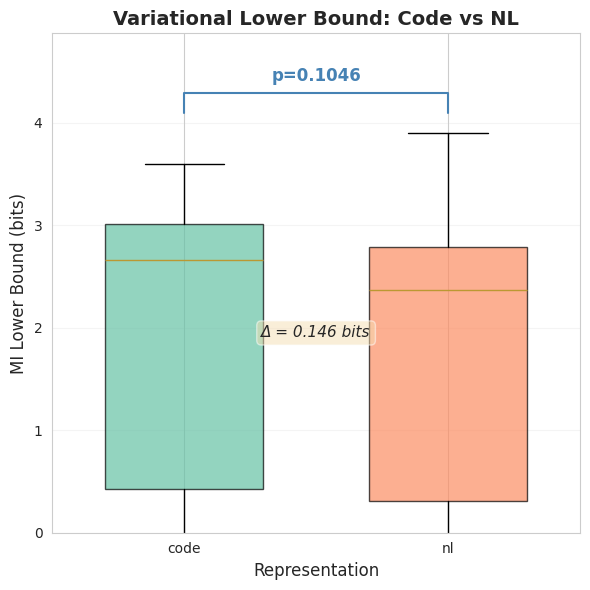

In [9]:
# Boxplot with p-values: Code vs NL MI lower bound
fig, ax = plt.subplots(figsize=(6, 6))

# Extract variational lower bound values for code and nl
mi_code = summary_corr_df[summary_corr_df["rep"] == "code"]["mutual_info_lower_bound_bits"].dropna()
mi_nl = summary_corr_df[summary_corr_df["rep"] == "nl"]["mutual_info_lower_bound_bits"].dropna()

# Use seaborn qualitative palette for categorical comparison
palette = sns.color_palette("Set2", n_colors=2)
colors = [palette[0], palette[1]]

# Create boxplot
bp = ax.boxplot([mi_code, mi_nl], tick_labels=["code", "nl"], patch_artist=True, widths=0.6)
bp["boxes"][0].set_facecolor(colors[0])
bp["boxes"][0].set_alpha(0.7)
bp["boxes"][1].set_facecolor(colors[1])
bp["boxes"][1].set_alpha(0.7)

# Calculate means for display
mi_code_mean = mi_code.mean()
mi_nl_mean = mi_nl.mean()
mean_diff = mi_code_mean - mi_nl_mean

# Create paired dataframe for Wilcoxon test
paired_df_box = summary_corr_df.pivot_table(index=["model", "seed"], columns="rep", values="mutual_info_lower_bound_bits").dropna(
    subset=["code", "nl"]
)

# Display p-value above the boxes
# Get the p-value from the Wilcoxon test
statistic, p_value = wilcoxon(paired_df_box["code"], paired_df_box["nl"], alternative="two-sided")
max_height = max(mi_code.max(), mi_nl.max())
y_pval = max_height + 0.1 * max_height

# Draw bracket and p-value
ax.plot([1, 1, 2, 2], [max_height + 0.05 * max_height, y_pval, y_pval, max_height + 0.05 * max_height], color="steelblue", linewidth=1.5)
ax.text(1.5, y_pval + 0.02 * max_height, f"p={p_value:.4f}", ha="center", va="bottom", fontsize=12, fontweight="bold", color="steelblue")

# Display mean difference
ax.text(
    1.5,
    max_height * 0.5,
    f"Δ = {mean_diff:.3f} bits",
    ha="center",
    va="center",
    fontsize=11,
    style="italic",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="wheat", alpha=0.5),
)

ax.set_ylabel("MI Lower Bound (bits)", fontsize=12)
ax.set_xlabel("Representation", fontsize=12)
ax.set_title("Variational Lower Bound: Code vs NL", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.2, axis="y")
ax.set_ylim(0, y_pval + 0.15 * max_height)

plt.tight_layout()
plt.savefig("boxplot_filtered.png", dpi=150)
plt.show()

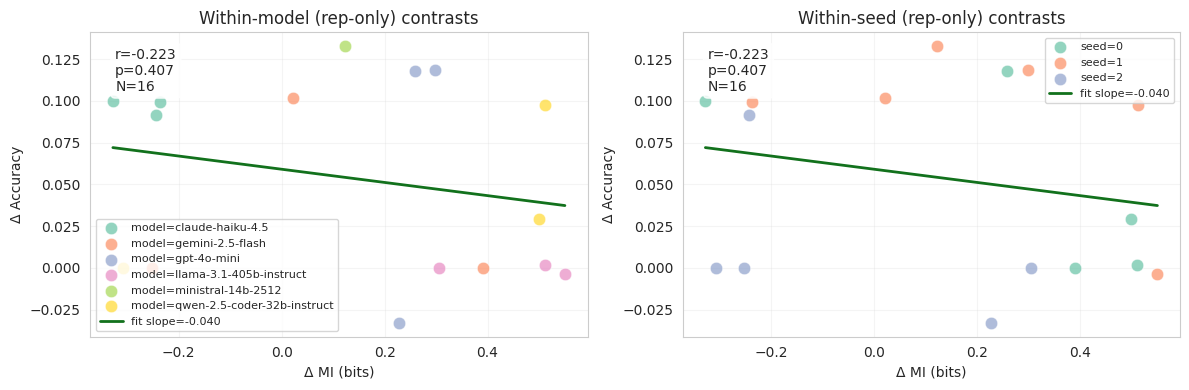

=== Contrast correlations (rep-only) ===
Within-model: r=-0.223, p=0.407, N=16
Within-seed:  r=-0.223, p=0.407, N=16


In [10]:
import itertools
from typing import List


def build_rep_only_contrasts(df: pd.DataFrame, group_cols: List[str]) -> pd.DataFrame:
    """Build contrasts where only representations differ (code vs nl).

    Groups are defined by the provided columns (e.g., model, seed). Within each
    group, all runs must share those identifiers; contrasts are only across rep.
    """

    rows = []
    for group_vals, gdf in df.groupby(group_cols):
        gdf = gdf.dropna(subset=["mutual_info_lower_bound_bits", "accuracy_performance"])
        if len(gdf) < 2:
            continue
        for (_, row_i), (_, row_j) in itertools.combinations(gdf.iterrows(), 2):
            rows.append(
                {
                    **{col: val for col, val in zip(group_cols, group_vals if isinstance(group_vals, tuple) else (group_vals,))},
                    "mi_diff": float(row_i["mutual_info_lower_bound_bits"] - row_j["mutual_info_lower_bound_bits"]),
                    "acc_diff": float(row_i["accuracy_performance"] - row_j["accuracy_performance"]),
                    "rep_i": row_i["rep"],
                    "rep_j": row_j["rep"],
                    "model": row_i.get("model"),
                    "seed": row_i.get("seed"),
                }
            )
    return pd.DataFrame(rows)


def plot_contrasts(ax, df: pd.DataFrame, title: str, color_key: str) -> tuple:
    if df.empty:
        ax.set_title(f"{title}\n(no contrasts)")
        ax.set_xlabel("Δ MI (bits)")
        ax.set_ylabel("Δ Accuracy")
        return float("nan"), float("nan"), 0

    # Use seaborn qualitative palette for categorical groups
    groups: List = sorted(df[color_key].unique())
    palette = sns.color_palette("Set2", n_colors=len(groups))
    color_map = {g: palette[i] for i, g in enumerate(groups)}
    for g, sub in df.groupby(color_key):
        ax.scatter(sub["mi_diff"], sub["acc_diff"], label=f"{color_key}={g}", alpha=0.7, color=color_map[g], s=80, edgecolors="white", linewidth=0.5)

    x = df["mi_diff"].to_numpy()
    y = df["acc_diff"].to_numpy()
    if len(df) >= 2:
        slope, intercept = np.polyfit(x, y, 1)
        x_line = np.linspace(x.min(), x.max(), 100)
        ax.plot(x_line, slope * x_line + intercept, color=sns.color_palette("dark")[2], lw=2, label=f"fit slope={slope:.3f}")
        r, p = pearsonr(x, y)
    else:
        r, p, slope = float("nan"), float("nan"), float("nan")

    ax.grid(True, alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel("Δ MI (bits)")
    ax.set_ylabel("Δ Accuracy")
    ax.legend(loc="best", fontsize=8)
    ax.annotate(
        f"r={r:.3f}\np={p:.3g}\nN={len(df)}",
        xy=(0.05, 0.95),
        xycoords="axes fraction",
        va="top",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )
    return r, p, len(df)


# Build contrast dataframes
within_rep_contrasts = build_rep_only_contrasts(summary_corr_df, ["model", "seed"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
r1, p1, n1 = plot_contrasts(axes[0], within_rep_contrasts, "Within-model (rep-only) contrasts", "model")
r2, p2, n2 = plot_contrasts(axes[1], within_rep_contrasts, "Within-seed (rep-only) contrasts", "seed")
plt.tight_layout()
plt.show()

print("=== Contrast correlations (rep-only) ===")
print(f"Within-model: r={r1:.3f}, p={p1:.3g}, N={n1}")
print(f"Within-seed:  r={r2:.3f}, p={p2:.3g}, N={n2}")

=== Descriptive Statistics ===

Code (N=16):
  Mean: 1.8833 bits
  Std:  1.5215 bits
  Min:  -0.6333 bits
  Max:  3.5940 bits

NL (N=16):
  Mean: 1.7378 bits
  Std:  1.6375 bits
  Min:  -0.6749 bits
  Max:  3.8978 bits

=== One-Way ANOVA Results ===
F-statistic: 0.0678
p-value: 0.7963
Eta-squared (effect size): 0.0023


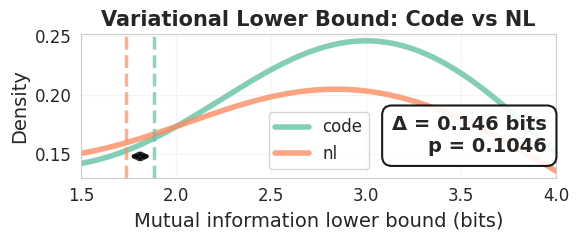

In [11]:
from scipy.stats import f_oneway

# Extract variational lower bound values for code and nl
mi_code = summary_corr_df[summary_corr_df["rep"] == "code"]["mutual_info_lower_bound_bits"].dropna()
mi_nl = summary_corr_df[summary_corr_df["rep"] == "nl"]["mutual_info_lower_bound_bits"].dropna()

# Descriptive statistics
print("=== Descriptive Statistics ===")
print(f"\nCode (N={len(mi_code)}):")
print(f"  Mean: {mi_code.mean():.4f} bits")
print(f"  Std:  {mi_code.std():.4f} bits")
print(f"  Min:  {mi_code.min():.4f} bits")
print(f"  Max:  {mi_code.max():.4f} bits")

print(f"\nNL (N={len(mi_nl)}):")
print(f"  Mean: {mi_nl.mean():.4f} bits")
print(f"  Std:  {mi_nl.std():.4f} bits")
print(f"  Min:  {mi_nl.min():.4f} bits")
print(f"  Max:  {mi_nl.max():.4f} bits")

# One-way ANOVA
f_stat, p_value = f_oneway(mi_code, mi_nl)

print("\n=== One-Way ANOVA Results ===")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4g}")

# Effect size (eta-squared)
ss_between = (
    len(mi_code) * (mi_code.mean() - summary_corr_df["mutual_info_lower_bound_bits"].mean()) ** 2
    + len(mi_nl) * (mi_nl.mean() - summary_corr_df["mutual_info_lower_bound_bits"].mean()) ** 2
)
ss_total = ((summary_corr_df["mutual_info_lower_bound_bits"].dropna() - summary_corr_df["mutual_info_lower_bound_bits"].dropna().mean()) ** 2).sum()
eta_squared = ss_between / ss_total if ss_total > 0 else 0.0
print(f"Eta-squared (effect size): {eta_squared:.4f}")

# Visualization: KDE density plot with lines
from scipy.stats import gaussian_kde, wilcoxon

# Create paired dataframe for Wilcoxon test
paired_df_plot = summary_corr_df.pivot_table(index=["model", "seed"], columns="rep", values="mutual_info_lower_bound_bits").dropna(
    subset=["code", "nl"]
)

# Compute Wilcoxon test
statistic, p_value = wilcoxon(paired_df_plot["code"], paired_df_plot["nl"], alternative="two-sided")

# Calculate mean difference
mean_diff = mi_code.mean() - mi_nl.mean()

fig, ax = plt.subplots(figsize=(6, 2.5))

# Use seaborn qualitative palette for categorical comparison
palette = sns.color_palette("Set2", n_colors=2)
colors = [palette[0], palette[1]]

# Create KDE plots for code and nl
kde_code = gaussian_kde(mi_code)
kde_nl = gaussian_kde(mi_nl)

# Create x-axis range (restricted to 1.5 to 4.0)
x_range = np.linspace(1.5, 4.0, 200)

# Plot density curves with thick lines
ax.plot(x_range, kde_code(x_range), color=colors[0], linewidth=4, label="code", alpha=0.8)
ax.plot(x_range, kde_nl(x_range), color=colors[1], linewidth=4, label="nl", alpha=0.8)

# Set x-axis limits
ax.set_xlim(1.5, 4.0)

# Add vertical lines for means
ax.axvline(mi_code.mean(), color=colors[0], linestyle="--", linewidth=2.5, alpha=0.7)
ax.axvline(mi_nl.mean(), color=colors[1], linestyle="--", linewidth=2.5, alpha=0.7)

# Add double arrow between means to emphasize difference
mean_code = mi_code.mean()
mean_nl = mi_nl.mean()
# Position arrow at a height that's visible above the density curves
max_density = max(kde_code(x_range).max(), kde_nl(x_range).max())
arrow_y = max_density * 0.6
ax.annotate("", xy=(mean_code, arrow_y), xytext=(mean_nl, arrow_y), arrowprops=dict(arrowstyle="<->", color="black", lw=3, alpha=0.8))

# Add text annotations for p-value and difference (moved lower)
ax.text(
    0.98,
    0.15,
    f"Δ = {mean_diff:.3f} bits\np = {p_value:.4f}",
    transform=ax.transAxes,
    fontsize=14,
    fontweight="bold",
    verticalalignment="bottom",
    horizontalalignment="right",
    bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.9, edgecolor="black", linewidth=1.5),
)

ax.set_ylabel("Density", fontsize=14)
ax.set_xlabel("Mutual information lower bound (bits)", fontsize=14)
ax.set_title("Variational Lower Bound: Code vs NL", fontsize=15, fontweight="bold")
ax.legend(fontsize=12)
ax.grid(True, alpha=0.2)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

Available models in data: ['claude-haiku-4.5', 'gemini-2.5-flash', 'gpt-4o-mini', 'llama-3.1-405b-instruct', 'ministral-14b-2512', 'qwen-2.5-coder-32b-instruct']

Models in paired data (have both code and nl): ['claude-haiku-4.5', 'gemini-2.5-flash', 'gpt-4o-mini', 'llama-3.1-405b-instruct', 'ministral-14b-2512', 'qwen-2.5-coder-32b-instruct']
Total models in paired data: 6
=== Paired Data Summary ===
Number of paired observations: 16

Differences (Code - NL):
  Mean: 0.1455 bits
  Std:  0.3253 bits
  Median: 0.2428 bits
  Min:  -0.3278 bits
  Max:  0.5503 bits

=== Wilcoxon Signed-Rank Test ===
Test statistic: 36.0000
p-value: 0.1046
Rank-biserial correlation (effect size): 0.7353
Number of models in plot: 6
Models: ['claude-haiku-4.5', 'gemini-2.5-flash', 'gpt-4o-mini', 'llama-3.1-405b-instruct', 'ministral-14b-2512', 'qwen-2.5-coder-32b-instruct']


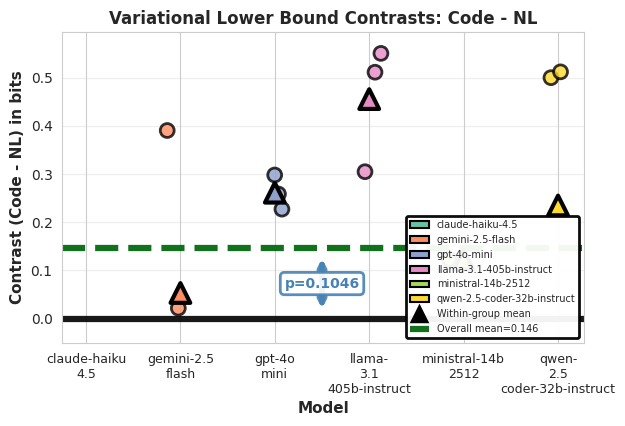

In [12]:
from scipy.stats import wilcoxon

# Create paired dataframe: for each (model, seed), get both code and nl values
paired_df = summary_corr_df.pivot_table(index=["model", "seed"], columns="rep", values="mutual_info_lower_bound_bits").reset_index()

# Check available models before filtering
all_models = summary_corr_df["model"].unique()
print(f"Available models in data: {sorted(all_models)}")

# Drop rows where either code or nl is missing
paired_df = paired_df.dropna(subset=["code", "nl"])

# Check which models are in paired data vs all available
models_in_paired = paired_df["model"].unique()
print(f"\nModels in paired data (have both code and nl): {sorted(models_in_paired)}")
print(f"Total models in paired data: {len(models_in_paired)}")

# Compute differences (code - nl) - positive means code > nl
paired_df["difference"] = paired_df["code"] - paired_df["nl"]

print("=== Paired Data Summary ===")
print(f"Number of paired observations: {len(paired_df)}")
print("\nDifferences (Code - NL):")
print(f"  Mean: {paired_df['difference'].mean():.4f} bits")
print(f"  Std:  {paired_df['difference'].std():.4f} bits")
print(f"  Median: {paired_df['difference'].median():.4f} bits")
print(f"  Min:  {paired_df['difference'].min():.4f} bits")
print(f"  Max:  {paired_df['difference'].max():.4f} bits")

# Wilcoxon signed-rank test
statistic, p_value = wilcoxon(paired_df["code"], paired_df["nl"], alternative="two-sided")

print("\n=== Wilcoxon Signed-Rank Test ===")
print(f"Test statistic: {statistic:.4f}")
print(f"p-value: {p_value:.4g}")

# Effect size (rank-biserial correlation)
n = len(paired_df)
r_biserial = 1 - (2 * statistic) / (n * (n + 1)) if n > 0 else 0.0
print(f"Rank-biserial correlation (effect size): {r_biserial:.4f}")

# Visualization: Contrast plot with scattered x positions by group
# Increased figure width to accommodate more models (including mistral) and improve spacing
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))

# Group by model and create jittered x positions
# Sort models to ensure consistent ordering and show all models
models = sorted(paired_df["model"].unique())
n_models = len(models)
print(f"Number of models in plot: {n_models}")
print(f"Models: {models}")
x_positions = []
y_values = []
colors = []
labels = []

# Use seaborn qualitative palette for models (categorical data)
palette_colors = sns.color_palette("Set2", n_colors=len(models))
color_map = {model: palette_colors[i] for i, model in enumerate(models)}

for i, (idx, row) in enumerate(paired_df.iterrows()):
    model = row["model"]
    model_idx = list(models).index(model)
    # Jitter x position within each model group
    jitter = np.random.uniform(-0.15, 0.15)
    x_pos = model_idx + 1 + jitter
    x_positions.append(x_pos)
    y_values.append(row["difference"])
    colors.append(color_map[model])
    labels.append(model)

# Scatter plot with thicker borders for better visibility
scatter = ax.scatter(x_positions, y_values, c=colors, alpha=0.8, s=100, edgecolors="black", linewidth=2.0, zorder=3)

# Calculate mean and get p-value
mean_diff = paired_df["difference"].mean()
statistic, p_value = wilcoxon(paired_df["code"], paired_df["nl"], alternative="two-sided")

# Calculate within-group means (mean for each model)
within_group_means = []
within_group_x = []
within_group_colors = []
for model in models:
    model_data = paired_df[paired_df["model"] == model]["difference"]
    if len(model_data) > 0:
        within_mean = model_data.mean()
        within_group_means.append(within_mean)
        model_idx = list(models).index(model)
        within_group_x.append(model_idx + 1)
        within_group_colors.append(color_map[model])

# Mark within-group means with triangles - thicker borders for visibility
triangle_marker = ax.scatter(
    within_group_x,
    within_group_means,
    marker="^",
    s=200,
    c=within_group_colors,
    edgecolors="black",
    linewidth=3.0,
    zorder=5,
    label="Within-group mean",
)

# Horizontal bar at zero (thicker and more visible)
ax.axhline(0, color="black", linestyle="-", linewidth=4.5, alpha=0.9, label="Zero difference", zorder=2)

# Mean line (thicker and more visible) - use seaborn dark palette for better contrast
mean_line = ax.axhline(
    mean_diff, color=sns.color_palette("dark")[2], linestyle="--", linewidth=4.5, alpha=1.0, label=f"Overall mean={mean_diff:.3f}", zorder=2
)

# Two-headed arrow between mean and zero with p-value (with margin) - thicker for visibility
# Position at the center of x-axis
x_center = (1 + n_models) / 2
# Add margin (10% of the distance)
margin = (mean_diff - 0) * 0.1
y_start = 0 + margin
y_end = mean_diff - margin
# Use annotate with arrowstyle for two-headed arrow - thicker line
ax.annotate("", xy=(x_center, y_end), xytext=(x_center, y_start), arrowprops=dict(arrowstyle="<->", color="steelblue", lw=4, alpha=0.9, zorder=1))
# Add p-value text on the arrow
ax.text(
    x_center,
    mean_diff / 2,
    f"p={p_value:.4f}",
    ha="center",
    va="center",
    fontsize=10,
    fontweight="bold",
    color="steelblue",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor="steelblue", linewidth=2),
)

# Set x-axis with wrapped labels to avoid overlap
ax.set_xticks(range(1, n_models + 1))


# Wrap labels intelligently to prevent overlap with better multi-line support
def wrap_model_label(model_name):
    """Wrap model name at strategic points to avoid overlap, using multiple lines if needed."""
    # Handle mistral models (e.g., mistralai/ministral-14b-2512)
    if "/" in model_name:
        parts = model_name.split("/", 1)
        # Further split the model part if it's long
        model_part = parts[1]
        if "-" in model_part:
            model_parts = model_part.split("-")
            if len(model_parts) >= 3:
                # Split into provider/model-name and version
                return f"{parts[0]}/\n{'-'.join(model_parts[:-1])}\n{model_parts[-1]}"
            else:
                return f"{parts[0]}/\n{model_part}"
        return f"{parts[0]}/\n{parts[1]}"
    elif "-" in model_name:
        parts = model_name.split("-")
        # For very long names (4+ parts), use 3 lines
        if len(parts) >= 4:
            # Split into: provider, middle parts, last part
            mid_point = len(parts) // 2
            return f"{parts[0]}-\n{'-'.join(parts[1:mid_point])}\n{'-'.join(parts[mid_point:])}"
        elif len(parts) == 3:
            # Split into: provider-model and version
            return f"{parts[0]}-{parts[1]}\n{parts[2]}"
        elif len(parts) == 2:
            return f"{parts[0]}\n{parts[1]}"
        else:
            return model_name
    else:
        return model_name


wrapped_labels = [wrap_model_label(model) for model in models]
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center", fontsize=9, linespacing=1.2)
ax.set_xlabel("Model", fontsize=11, fontweight="bold")
ax.set_ylabel("Contrast (Code - NL) in bits", fontsize=11, fontweight="bold")
ax.set_title("Variational Lower Bound Contrasts: Code - NL", fontsize=12, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y", linewidth=1.0)

# Extend y-axis to -0.05 to emphasize all values are positive
ax.set_ylim(-0.05, None)

# Add legend for models, mean, and triangle marker - with thicker borders for visibility
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [Patch(facecolor=color_map[model], label=model, edgecolor="black", linewidth=1.5) for model in models]
# Add triangle marker to legend - thicker border
triangle_legend = Line2D([0], [0], marker="^", color="black", linestyle="None", markersize=10, markeredgewidth=2.5, label="Within-group mean")
# Place legend at bottom right of the plot - with thicker frame border
legend = ax.legend(handles=legend_elements + [triangle_legend, mean_line], loc="lower right", fontsize=7, frameon=True, framealpha=0.95)
legend.get_frame().set_linewidth(2.0)
legend.get_frame().set_edgecolor("black")

# Adjust margins to accommodate multi-line labels and improve visibility
# Increased bottom margin for better label spacing
plt.subplots_adjust(right=0.97, left=0.10, top=0.94, bottom=0.25)  # Extra bottom space for multi-line wrapped labels
plt.show()

Pearson r = 0.373, p = 0.0355, N = 32


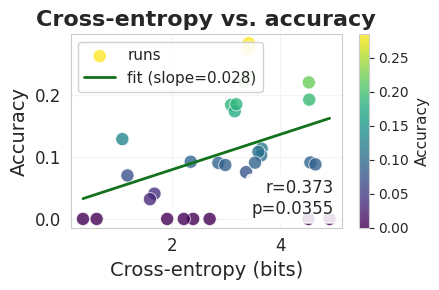

In [13]:
# Correlation: cross-entropy (bits) vs accuracy


def build_summary_with_ce(merged: Dict[Tuple[str, int, str], pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for (model, seed, rep), df in merged.items():
        metrics_row = df[df["cross_entropy_bits"].notna()].tail(1)
        if metrics_row.empty:
            continue
        ce_bits = float(metrics_row["cross_entropy_bits"].iloc[0])
        acc_perf = float(df["accuracy_performance"].iloc[0])
        rows.append(
            {
                "model": model,
                "seed": seed,
                "rep": rep,
                "cross_entropy_bits": ce_bits,
                "accuracy_performance": acc_perf,
            }
        )
    return pd.DataFrame(rows)


summary_ce_df = build_summary_with_ce(merged_dfs)
clean_ce = summary_ce_df.dropna(subset=["cross_entropy_bits", "accuracy_performance"])

if len(clean_ce) < 2 or clean_ce["cross_entropy_bits"].nunique() < 2:
    print("Not enough distinct points for correlation.")
else:
    r_ce, p_ce = pearsonr(clean_ce["cross_entropy_bits"], clean_ce["accuracy_performance"])
    print(f"Pearson r = {r_ce:.3f}, p = {p_ce:.3g}, N = {len(clean_ce)}")

    x_ce = clean_ce["cross_entropy_bits"].to_numpy()
    y_ce = clean_ce["accuracy_performance"].to_numpy()

    slope_ce, intercept_ce = np.polyfit(x_ce, y_ce, 1)
    x_line_ce = np.linspace(x_ce.min(), x_ce.max(), 100)
    y_line_ce = slope_ce * x_line_ce + intercept_ce

    # Color by accuracy to leverage the viridis colormap
    plt.figure(figsize=(4.5, 3))
    scatter = plt.scatter(
        x_ce,
        y_ce,
        c=y_ce,
        cmap="viridis",
        alpha=0.8,
        s=90,
        edgecolors="white",
        linewidth=0.6,
        label="runs",
    )
    cbar = plt.colorbar(scatter)
    cbar.set_label("Accuracy", fontsize=11)

    plt.plot(
        x_line_ce,
        y_line_ce,
        color=sns.color_palette("dark")[2],
        linewidth=2,
        label=f"fit (slope={slope_ce:.3f})",
    )
    plt.xlabel("Cross-entropy (bits)", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.title("Cross-entropy vs. accuracy", fontsize=16, fontweight="bold")
    plt.legend(fontsize=11, loc="upper left", framealpha=0.9)
    plt.grid(True, alpha=0.2)
    # Place annotation in lower-right to avoid legend/labels
    plt.annotate(
        f"r={r_ce:.3f}\np={p_ce:.3g}",
        xy=(0.97, 0.05),
        xycoords="axes fraction",
        ha="right",
        va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
        fontsize=12,
    )
    plt.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

Pearson r = 0.488, p = 0.0046, N = 32


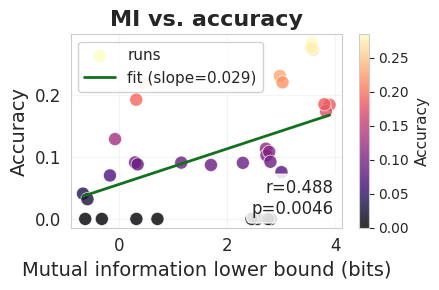

In [14]:
# Compute Pearson correlation and plot scatter with regression line
clean_df = summary_corr_df.dropna(subset=["mutual_info_lower_bound_bits", "accuracy_performance"])

r, p = pearsonr(clean_df["mutual_info_lower_bound_bits"], clean_df["accuracy_performance"])
print(f"Pearson r = {r:.3f}, p = {p:.3g}, N = {len(clean_df)}")

x = clean_df["mutual_info_lower_bound_bits"].to_numpy()
y = clean_df["accuracy_performance"].to_numpy()

# Fit regression line
slope, intercept = np.polyfit(x, y, 1)
x_line = np.linspace(x.min(), x.max(), 100)
y_line = slope * x_line + intercept

# Color by accuracy using magma colormap
plt.figure(figsize=(4.5, 3))
scatter = plt.scatter(
    x,
    y,
    c=y,
    cmap="magma",
    alpha=0.8,
    s=90,
    edgecolors="white",
    linewidth=0.6,
    label="runs",
)
cbar = plt.colorbar(scatter)
cbar.set_label("Accuracy", fontsize=11)

plt.plot(
    x_line,
    y_line,
    color=sns.color_palette("dark")[2],
    linewidth=2,
    label=f"fit (slope={slope:.3f})",
)
plt.xlabel("Mutual information lower bound (bits)", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("MI vs. accuracy", fontsize=16, fontweight="bold")
plt.legend(fontsize=11, loc="upper left", framealpha=0.9)
plt.grid(True, alpha=0.2)
plt.annotate(
    f"r={r:.3f}\np={p:.3g}",
    xy=(0.97, 0.05),
    xycoords="axes fraction",
    ha="right",
    va="bottom",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.85),
    fontsize=12,
)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()